# System Info

In [1]:
versioninfo()

Julia Version 1.5.1
Commit 697e782ab8 (2020-08-25 20:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 2
  JULIA_EDITOR = "/home/user/.vscode-server-insiders/bin/f5d3ba4d61146b78f0c75c82f3f85232d3409bc1/bin/code-insiders"
  JULIA_PATH = /usr/local/julia
  JULIA_GPG = 3673DF529D9049477F76B37566E3C7DC03D6E495
  JULIA_VERSION = 1.5.1


# Setup

In [2]:
cd("..")

In [3]:
# how many iterations of HMC to do
iters = 1000;

# Packages

In [4]:
include("../src/Utils.jl")
using .Utils

In [5]:
using Pipe
using Query
using VegaLite
using DataFrames
using Turing
using StatsPlots

# Dataset

In [6]:
howel = get_data("Howell1") |>
    @select(:height, :weight) |>
    DataFrame

first(howel, 5)

,height,weight
,Float64,Float64
1,151.765,47.8256
2,139.7,36.4858
3,136.525,31.8648
4,156.845,53.0419
5,145.415,41.2769


In [7]:
size(howel)

(544, 2)

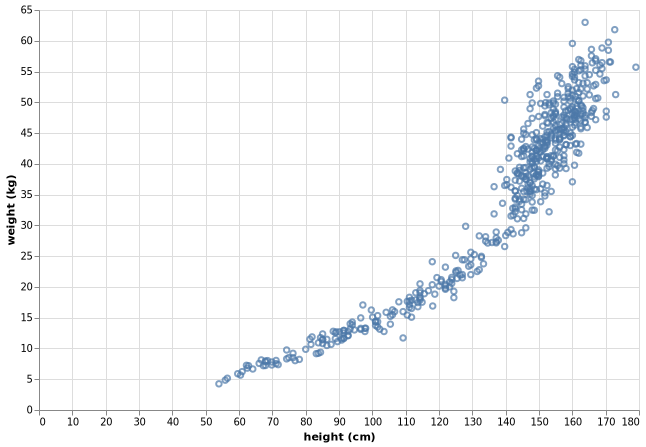

In [8]:
main_plot = howel |>
    @vlplot(:point,
            x = {:height, title = "height (cm)"},
            y = {:weight, title = "weight (kg)"},
            height = 400,
            width = 600)

# Modelling

## Statistical Model

### Simple Linear Regression

A simple linear regression model:

In [9]:
@model function lm_model(height, weight)
    N = length(height)
    
    σ ~ Exponential(1)
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    
    for i in 1:N
       μᵢ = α + β * height[i]
       weight[i] ~ Normal(μᵢ, σ)
    end
end;

In [10]:
height = howel[:, :height]
weight = howel[:, :weight]

chain1 = sample(lm_model(height, weight), NUTS(), iters);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, fa

In [11]:
chain1

Chains MCMC chain (500×15×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat  
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64  
                                                                             
           α   -33.5552    1.0681     0.0478    0.0735   187.0657    0.9985  
           β     0.5002    0.0075     0.0003    0.0006   171.9877    0.9982  
           σ     4.9785    0.1478     0.0066    0.0071   208.7613    0.9980  

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5%  
      Symbol    Float64    Float64    Float64    Float64 

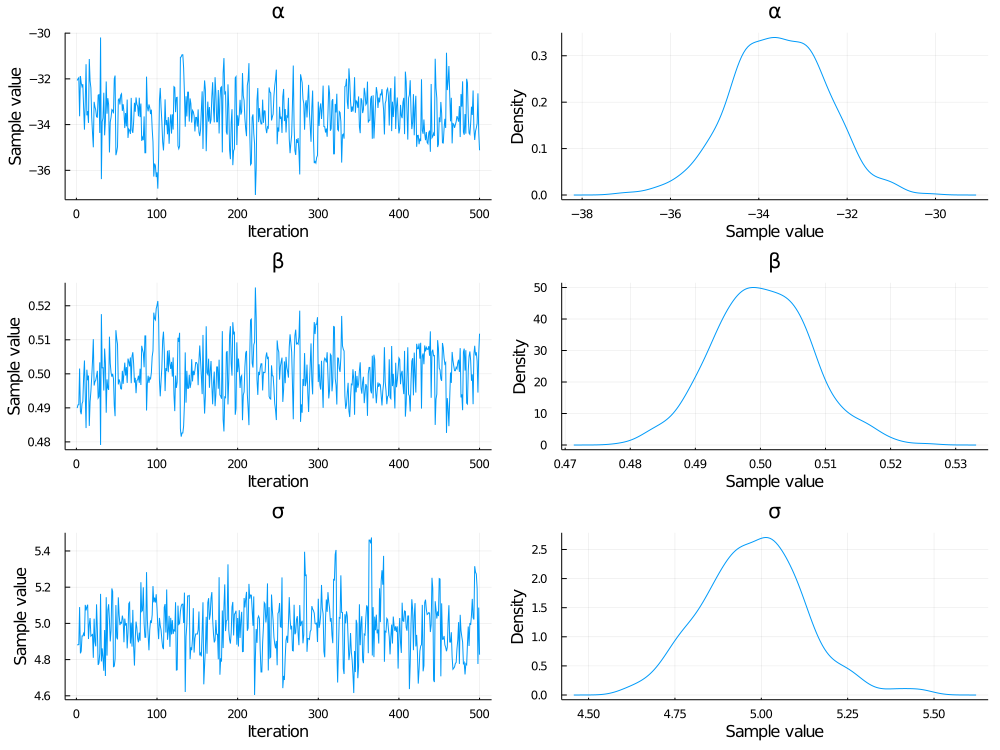

In [12]:
plot(chain1)

Get the predictions:

In [13]:
c = DataFrame(chain1)[:, :α] |> mean
m = DataFrame(chain1)[:, :β] |> mean

# @mutate is referencing a global variable, Query.jl will convert all types to Any
# see: https://discourse.julialang.org/t/query-mutate-changes-other-column-type/39292/6
howel = howel |>
    @mutate(lm_pred = m * _.height + c) |>
    DataFrame;

Visualize the fit:

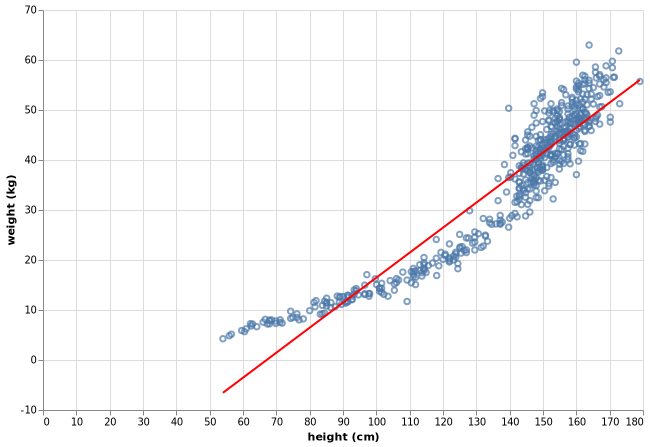

In [14]:
howel |>
    @vlplot() +
    @vlplot(:point,
            x =  {:height, title = "height (cm)", type = "quantitative"},
            y = "weight:q"
    ) +
    @vlplot(:line,
            x = "height:q",
            y = {:lm_pred, title = "weight (kg)", type = "quantitative"},
            color = {value = :red},
            height = 400,
            width = 600)

### Simple Linear Regression With A Transformation

In [15]:
@model function lm_model2(height, weight)
    N = length(height)
    
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    
    for i in 1:N
       μᵢ = α + β * height[i]
       weight[i] ~ LogNormal(μᵢ, 1)
    end
end;

In [16]:
chain2 = sample(lm_model2(height, weight), NUTS(), iters);

┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/user/.julia/packages/Turing/G7n2S/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:24


In [17]:
chain2

Chains MCMC chain (500×14×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = α, β
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat  
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64  
                                                                           
           α    0.6091    0.2412     0.0108    0.0312   57.5867    1.0012  
           β    0.0205    0.0017     0.0001    0.0002   61.2102    1.0011  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
           α    0.1982 

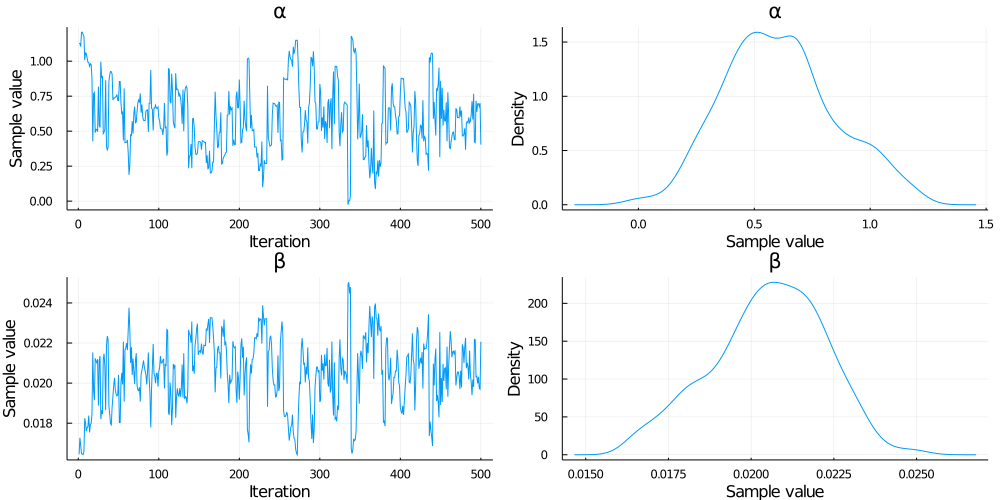

In [18]:
plot(chain2)

Get the predictions:

In [19]:
c = DataFrame(chain2)[:, :α] |> mean
m = DataFrame(chain2)[:, :β] |> mean

howel = howel |>
    @mutate(lm2_pred = exp(m * _.height + c)) |>
    DataFrame;

Visualize the fit:

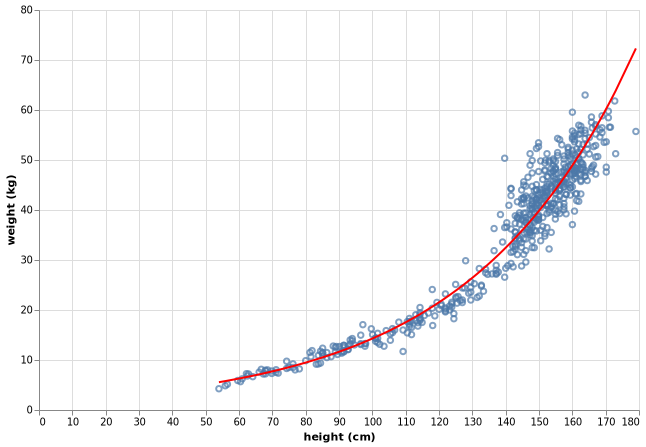

In [20]:
howel |>
    @vlplot() +
    @vlplot(:point,
            x = {:height, title = "height (cm)", type = "quantitative"},
            y = "weight:q"
    ) +
    @vlplot(:line,
            x = "height:q",
            y = {:lm2_pred, title = "weight (kg)", type = "quantitative"},
            color = {value = :red},
            height = 400,
            width = 600)

## Scientific Model

Assume a human is a cylinder:

In [21]:
@model function sci_model(height, weight)
    N = length(height)
    
    σ ~ Exponential(1)
    
    # k is kg/cm3, the density of a human body
    # assume it is 2 grams/ml. See: https://bit.ly/2SOLRHC
    # 2 grams/ml => 0.002 kg/cm3
    k ~ Exponential(0.002)
    
    # p is definitely between 0 and 1
    # pretty sure it's less than 0.5 (people are alot taller than they are wider)
    # assume the mean is 0.1
    p ~ Beta(2, 18)
    
    for i in 1:N
       μᵢ = log(k * π * p^2 * height[i]^3)
       weight[i] ~ LogNormal(μᵢ, σ)
    end
end;

In [22]:
chain3 = sample(sci_model(height, weight), NUTS(), iters);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/user/.julia/packages/Turing/G7n2S/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:08:38


In [23]:
chain3

Chains MCMC chain (500×15×1 Array{Float64,3}):

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = k, p, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat  
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64  
                                                                            
           k    0.0014    0.0013     0.0001    0.0000   162.4206    0.9980  
           p    0.0721    0.0369     0.0016    0.0015   123.9057    1.0002  
           σ    0.2074    0.0063     0.0003    0.0004   263.4297    0.9980  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
   

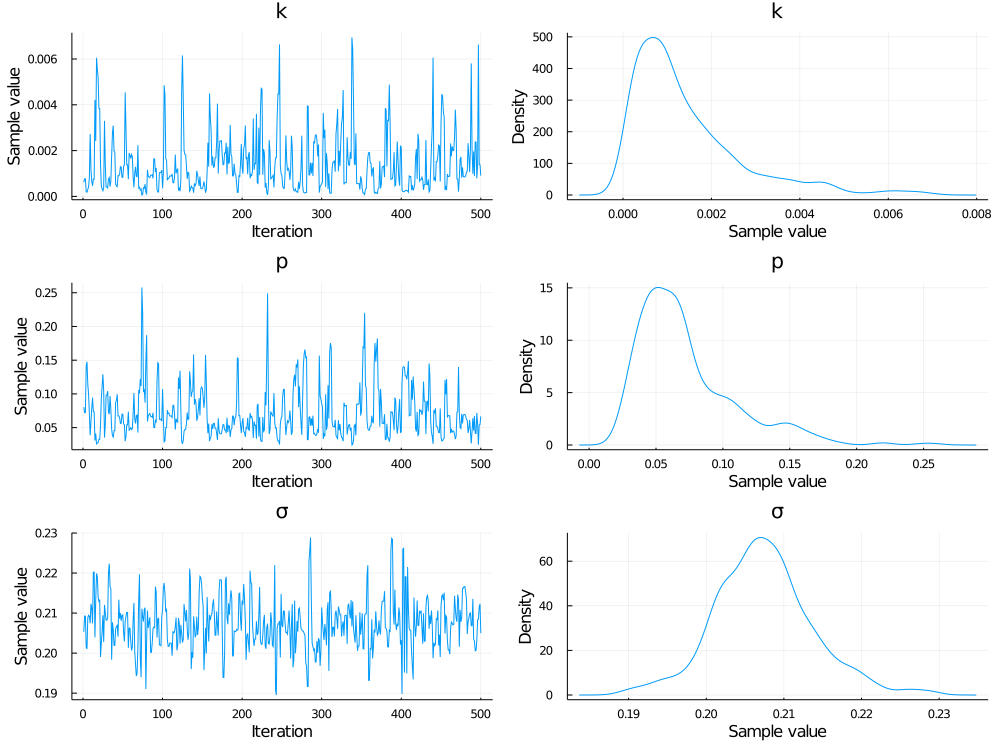

In [24]:
plot(chain3)

Get the predictions:

In [25]:
# for each sampled parameter from the chain, compute the prediction using the scientific model, then take the mean
function build_pred_fn(chain)
    params = DataFrame(chain) |>
    @select(:k, :p)
    
    (height::Float64) -> params |> 
        @mutate(mu = _.k * π * _.p^2 * height^3) |> 
        @select(:mu) |> 
        DataFrame |> 
        Matrix |> 
        mean
    
end

pred_fn = build_pred_fn(chain3)

howel[:, :sci_pred] = pred_fn.(howel[:, :height]);

Visualize it:

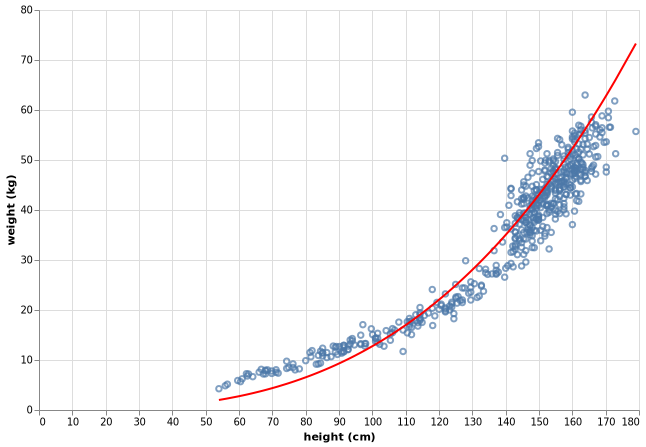

In [26]:
howel |>
    @vlplot() +
    @vlplot(:point,
            x = {"height", type = "quantitative", title = "height (cm)"},
            y = "weight:q"
    ) +
    @vlplot(:line,
            x = "height:q",
            y = {:sci_pred, title = "weight (kg)", type = "quantitative"},
            color = {value = :red},
            height = 400,
            width = 600)

# Results

Plot all model results into 1 chart:

In [27]:
function build_pred_fn_lm(chain)
    params = DataFrame(chain) |>
    @select(:α, :β)
    
    (height) -> params |> 
        @mutate(mu = _.α + _.β * height) |> 
        @select(:mu) |> 
        DataFrame |> 
        Matrix |> 
        mean
    
end;

In [28]:
pred_fn_m1 = build_pred_fn_lm(chain1)
pred_fn_m2 = build_pred_fn_lm(chain2)

h = howel[:, :height]

results = howel |> 
    @select(:height, :weight) |>
    DataFrame

results[:, :"model 1"] = pred_fn_m1.(h)
results[:, :"model 2"] = exp.(pred_fn_m2.(h)) # because model 2 assume log(w) ~ h
results[:, :"model 3"] = pred_fn.(h) # from previous section

first(results, 5)

,height,weight,model 1,model 2,model 3
,Any,Any,Float64,Float64,Float64
1,151.765,47.8256,42.3623,41.3106,44.6176
2,139.7,36.4858,36.327,32.2565,34.8001
3,136.525,31.8648,34.7388,30.2234,32.4809
4,156.845,53.0419,44.9035,45.846,49.2496
5,145.415,41.2769,39.1859,36.2671,39.2481


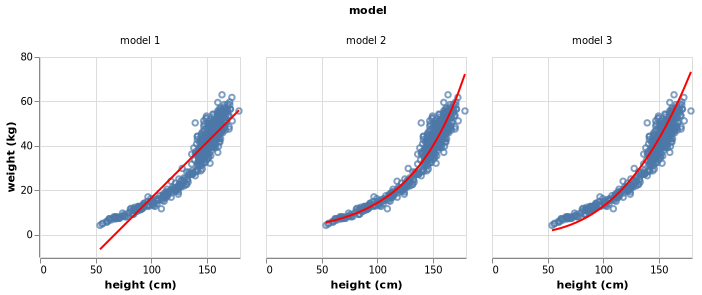

In [29]:
@pipe results |>
    DataFrames.stack(_, [:"model 1", :"model 2", :"model 3"]) |>
    rename(_, ["variable" => "model", "value" => "prediction"]) |>
    @vlplot(
        facet = {column =  {field = "model", type = "nominal"}},
        spec = {
                layer = [
                            {:point, x = {"height", type = "quantitative", title = "height (cm)"}, y = {"weight:q"}},
                            {:line, x = "height:q", y = {"prediction", title = "weight (kg)"}, color = {value = "red"}}
                        ]
                }
    )